In [1]:
# Example of chaotic migration using dynamical tides operator
import rebound
import reboundx
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 14})

# intial conditions
a0 = 1.5
e0 = 0.985
R_planet = 1.6 * 4.67e-4 # 1.6 Jupiter radii
m_planet = 1e-3 # approximately 1 Jupiter mass

# create simulation
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=m_planet, r=R_planet, a=a0, e=e0)
sim.move_to_com()

# load reboundx and the dynamical tides operator
rebx = reboundx.Extras(sim)
td = rebx.load_force('tides_dynamical')
rebx.add_force(td)

# set dP_crit = 0 to always carry out mode evolution
sim.particles[1].params['td_dP_crit'] = 0

# set initial modes to 0
sim.particles[1].params['td_c_imag'] = 0
sim.particles[1].params['td_c_real'] = 0
#sim.particles[1].params['td_num_periapse'] = 0

# record initial orbital energy
o = sim.particles[1].orbit(primary=sim.particles[0])
EB0 = -sim.G * sim.particles[1].m * sim.particles[0].m / (2 * o.a)

N = 5000
t = np.linspace(0, 2e4, N) # time
a = np.zeros(N) # semi-major axis
e = np.zeros(N) # eccentricity
E = np.zeros(N) # mode energy
E_sim = np.zeros(N) # simulation energy
L = np.zeros((N, 3)) # total angular momentum

c_imag = np.zeros(N)
c_real = np.zeros(N)

for i, time in enumerate(t):
    o = sim.particles[1].orbit(primary=sim.particles[0])
    a[i] = o.a
    e[i] = o.e
    L[i, :] = sim.angular_momentum() 
    E[i] = abs(EB0) * (sim.particles[1].params['td_c_imag']**2 + sim.particles[1].params['td_c_real']**2)
    E_sim[i] = sim.energy()
    c_imag[i] = sim.particles[1].params['td_c_imag']
    c_real[i] = sim.particles[1].params['td_c_real']

    if i % 100 == 0 and i != 0:
        print(time, o.a, o.e, E[i], sim.particles[1].params['td_dP_hat'])
    
    sim.integrate(2 * np.pi * time)
    



400.0800160032006 1.4950393500098769 0.9849502514593533 1.0959664351384802e-06 54.675102437008874 0.00021122664846177425
800.1600320064013 1.4350461065293159 0.984321381995664 1.4951174473389429e-05 210.2547906063726 0.00021119118362549185
1200.2400480096019 1.3702114462375758 0.9835798801060847 3.3497086534556364e-05 258.4904157240828 0.00021114935834757543
1600.3200640128025 1.2983076149743902 0.9826709648889067 5.225165619869933e-05 288.0519915914335 0.00021109807723392643
2000.4000800160031 1.2774302301440277 0.9823879026234043 5.7530910609382915e-05 290.8432479043268 0.00021108210396770868
2400.4800960192038 1.261088564273764 0.9821598015050403 6.254645762925236e-05 294.01014230533804 0.00021106923118342953
2800.560112022404 1.0552423694538817 0.9786819633731326 3.756075377277865e-06 51.14792368990537 0.00021087285160659812
3200.640128025605 1.0581797837934375 0.9787411021081066 2.4510355963482215e-06 45.2048578470794 0.00021087619265137543
3600.7201440288054 0.8112182552683614 0.

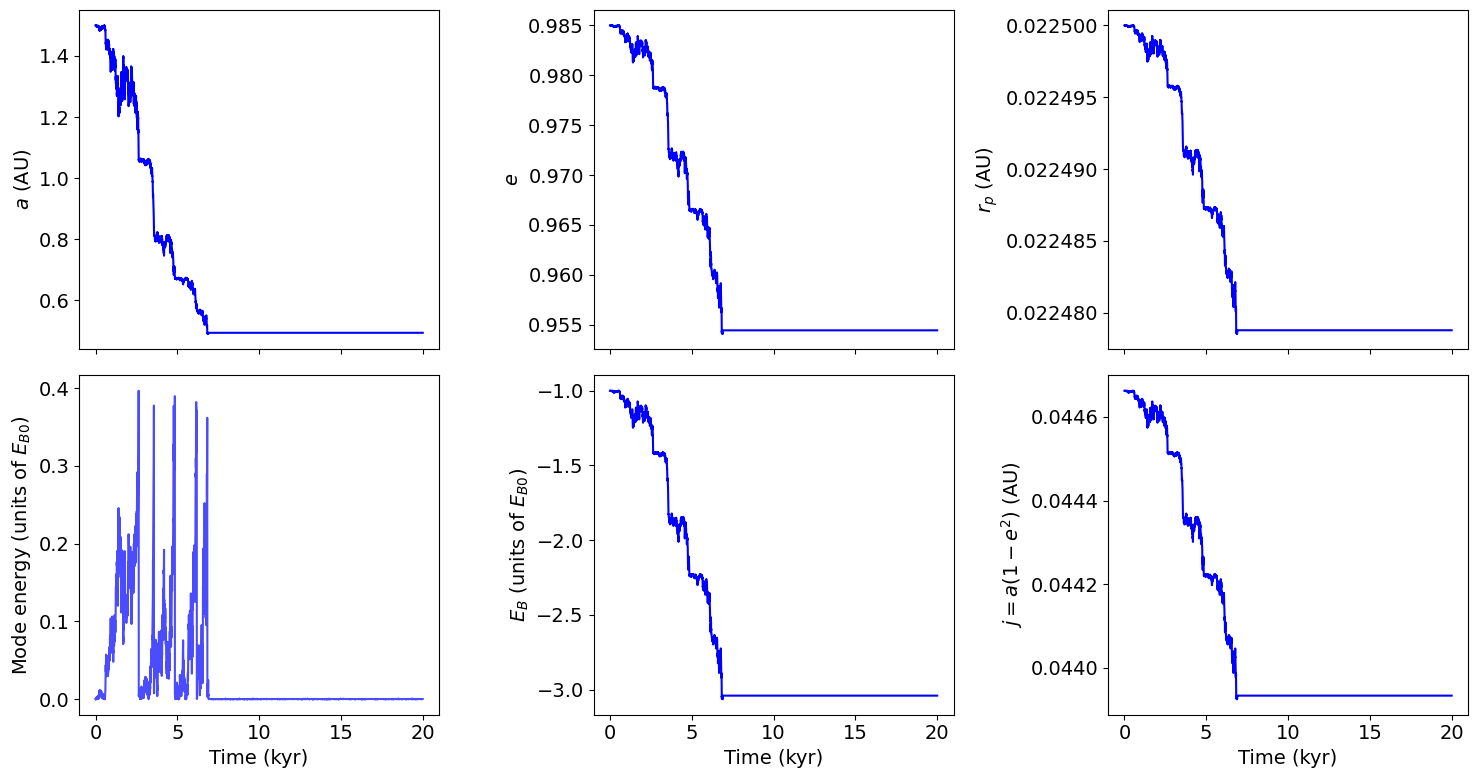

In [2]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(15)


axes[0, 0].plot(t / 1e3, a, c='blue')
axes[0, 0].set_ylabel(r'$a$ (AU)')

axes[0, 1].plot(t / 1e3, e, c='blue')
axes[0, 1].set_ylabel(r'$e$')

axes[1, 0].plot(t / 1e3, -E / EB0, alpha=0.7, c='blue')
axes[1, 0].set_ylabel(r'Mode energy (units of $E_{B0}$)')
axes[1, 0].set_xlabel(r'Time (kyr)')

axes[1, 1].plot(t / 1e3, -E_sim / EB0, c='blue')
axes[1, 1].set_ylabel(r'$E_B$ (units of $E_{B0}$)')
axes[1, 1].set_xlabel(r'Time (kyr)')

axes[0, 2].plot(t / 1e3, a * (1-e), c='blue')
axes[0, 2].set_ylabel(r'$r_p$ (AU)')


axes[1, 2].plot(t / 1e3, a * (1-e**2), c='blue')
axes[1, 2].set_ylabel(r'$j = a(1-e^2)$ (AU)')
axes[1, 2].set_xlabel(r'Time (kyr)')

plt.tight_layout()
